In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [4]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

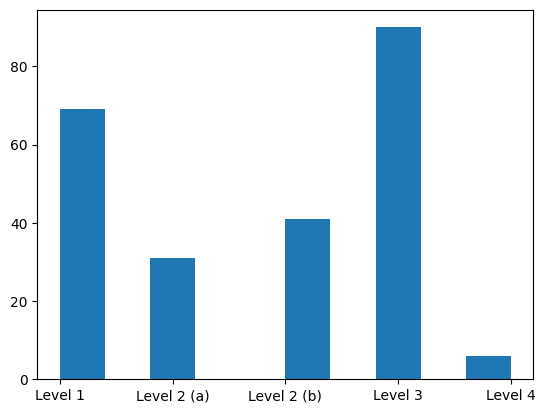

In [5]:
plt.hist(sorted(df['Code']))

In [6]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    ordinal_mapping = ['Level 1', 'Level 2 (a)', 'Level 2 (b)', 'Level 3', 'Level 4']  # Ensure correct order
    oe = OrdinalEncoder(categories=[ordinal_mapping]) # Define order
    df['class'] = oe.fit_transform(df[['Code']]).astype(int).flatten()

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, oe

In [7]:
df_resampled, ordinal_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [8]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

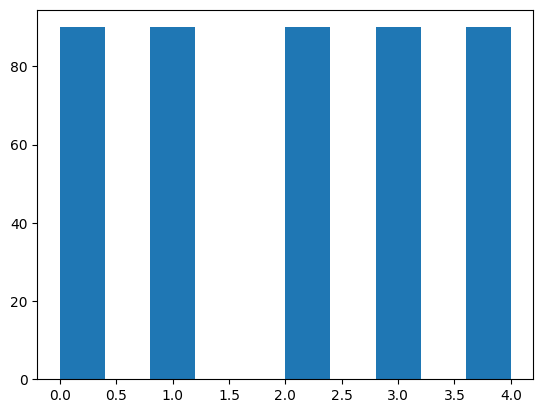

In [9]:
plt.hist(sorted(df_resampled['class']))

In [10]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

Validation Set Results:
Accuracy: 0.63
Cohen's Kappa: 0.53
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.52      0.93      0.67        14
           2       0.50      1.00      0.67        13
           3       0.00      0.00      0.00        13
           4       1.00      1.00      1.00        14

    accuracy                           0.63        67
   macro avg       0.60      0.62      0.52        67
weighted avg       0.61      0.63      0.53        67



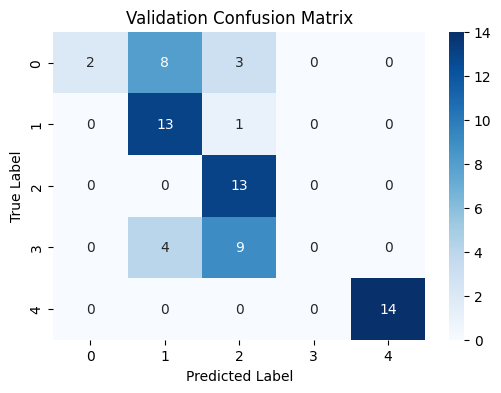


Test Set Results:
Accuracy: 0.63
Cohen's Kappa: 0.54
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        14
           1       0.52      0.92      0.67        13
           2       0.48      0.93      0.63        14
           3       1.00      0.07      0.13        14
           4       1.00      1.00      1.00        13

    accuracy                           0.63        68
   macro avg       0.80      0.64      0.58        68
weighted avg       0.80      0.63      0.57        68



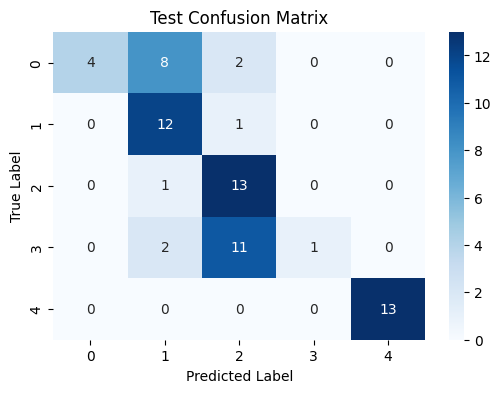

In [11]:
# Train SVM Ordinal Regression (SVR with linear kernel)
ordinal_svm = SVR(kernel="linear")
ordinal_svm.fit(X_train_tfidf, y_train)

# Predictions (round to nearest class)
ordsvm_y_val_pred = ordinal_svm.predict(X_val_tfidf).round().astype(int)
ordsvm_y_test_pred = ordinal_svm.predict(X_test_tfidf).round().astype(int)

# Ensure predictions are within class range
ordsvm_y_val_pred = np.clip(ordsvm_y_val_pred, np.min(y_train), np.max(y_train))
ordsvm_y_test_pred = np.clip(ordsvm_y_test_pred, np.min(y_train), np.max(y_train))

# Evaludation metrics for validation set
ordsvm_val_accuracy = accuracy_score(y_val, ordsvm_y_val_pred)
ordsvm_val_class_report = classification_report(y_val, ordsvm_y_val_pred, zero_division=0)
ordsvm_val_cohen_kappa = cohen_kappa_score(y_val, ordsvm_y_val_pred)
ordsvm_val_cm = confusion_matrix(y_val, ordsvm_y_val_pred)

# Evaludation metrics for test set
ordsvm_test_accuracy = accuracy_score(y_test, ordsvm_y_test_pred)
ordsvm_test_class_report = classification_report(y_test, ordsvm_y_test_pred, zero_division=0)
ordsvm_test_cohen_kappa = cohen_kappa_score(y_test, ordsvm_y_test_pred)
ordsvm_test_cm = confusion_matrix(y_test, ordsvm_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {ordsvm_val_accuracy:.2f}")
print(f"Cohen's Kappa: {ordsvm_val_cohen_kappa:.2f}")
print("Classification Report:")
print(ordsvm_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(ordsvm_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {ordsvm_test_accuracy:.2f}")
print(f"Cohen's Kappa: {ordsvm_test_cohen_kappa:.2f}")
print("Classification Report:")
print(ordsvm_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(ordsvm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [17]:
# Get the feature importance (coefficients)
coefs = ordinal_svm.coef_.toarray().flatten()

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# For each class, compute average TF-IDF vector and multiply by model coefficients
for class_label in sorted(y_train.unique()):
    print(f"\nTop words for class {class_label}:")

    # Get rows (documents) that belong to this class
    class_docs = X_train_tfidf[np.array(y_train) == class_label]

    # Compute average TF-IDF vector for this class
    class_avg_tfidf = class_docs.mean(axis=0).A1  # shape (n_features,), converted to dense array

    # Compute per-feature importance scores: how much each feature contributes
    feature_scores = class_avg_tfidf * coefs  # element-wise multiplication

    # Get indices of top 10 features
    top10_idx = feature_scores.argsort()[-10:][::-1]

    # Display the top 10 words and their scores
    for idx in top10_idx:
        print(f"{feature_names[idx]}: {feature_scores[idx]:.4f}")


Top words for class 0:
course: 0.0180
project: 0.0158
people: 0.0114
make: 0.0097
understand: 0.0084
important: 0.0071
making: 0.0069
ai: 0.0066
social: 0.0065
work: 0.0063

Top words for class 1:
concepts: 0.0301
course: 0.0297
approach: 0.0137
new: 0.0130
project: 0.0115
social: 0.0110
ai: 0.0110
document: 0.0094
work: 0.0092
context: 0.0079

Top words for class 2:
course: 0.0449
understand: 0.0235
new: 0.0233
given: 0.0190
people: 0.0151
project: 0.0132
work: 0.0129
score: 0.0114
learnt: 0.0114
thinking: 0.0107

Top words for class 3:
project: 0.0332
understand: 0.0330
new: 0.0317
decision: 0.0292
people: 0.0288
concepts: 0.0274
course: 0.0240
making: 0.0238
good: 0.0174
things: 0.0173

Top words for class 4:
social: 0.0972
society: 0.0844
document: 0.0761
impact: 0.0664
project: 0.0522
things: 0.0447
feel: 0.0434
context: 0.0433
responsibility: 0.0404
important: 0.0389


In [18]:
# Get the top 20 most important features globally
top20_idx = np.argsort(np.abs(coefs))[-20:][::-1]
print("\nTop 20 Important Features (by weight):")
for idx in top20_idx:
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")


Top 20 Important Features (by weight):
understand: 1.3418
processing: -1.3263
science: -1.2793
lectures: -1.2274
new: 1.2082
feel: 1.2067
society: 1.1319
decision: 1.1032
document: 1.1026
things: 1.0765
people: 1.0684
data: -1.0280
social: 1.0170
impact: 1.0071
project: 0.9793
good: 0.9468
personal: 0.9289
improve: -0.9277
helps: -0.8904
believe: 0.8676
